In [2]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain
from bs4 import BeautifulSoup # I mamba installed bs4
import requests

from datetime import date
import shapely

sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [3]:
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_only/April_1_unmerged_fires_with_FWI.csv"

fires = fv.prep_fire_files(path)
#fires = fires.set_crs("4326")
#fires = fires.set_crs("3571")
proj_fires = fires[~fires.geometry.isna()].to_crs("4326")
#proj_fires = fires[~fires.geometry.isna()]
proj_fires.t = proj_fires.t.astype("datetime64[ns]")
proj_fires["days_since"] = (proj_fires.t - proj_fires.t.min())
proj_fires["days_since"] = proj_fires["days_since"].dt.days

print(proj_fires.t.max())
print(proj_fires.t.min())

2023-09-26 00:00:00
2023-05-29 12:00:00


In [4]:
import matplotlib as mpl
import cartopy.crs as ccrs

In [55]:
### Read in Supression zones

zones = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/supression_zones_quebec/Full_response_limit.shp")
zones= zones.set_crs(32198)

zones = zones.to_crs("4326")



In [56]:
zones['geometry'] = shapely.unary_union(zones.geometry)

In [57]:
def get_mid_line(bounds):
    mid_x = (bounds[0] + bounds[2])/2
    mid_y = (bounds[1] + bounds[3])/2
    mid_line = shapely.LineString([[bounds[0], mid_y], [mid_x, mid_y], [bounds[2], mid_y]])
    return(mid_line)
    

In [58]:

zones_avg_line = zones.copy()
zones_avg_line['geometry'] = get_mid_line(zones.geometry[0].bounds)


In [11]:
eco_provs_n = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/Eco_prov_and_supression/QCAnalysis/QC_NorthernEcoregions_LimitedResponseZone.shp")

eco_provs_s = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/Eco_prov_and_supression/QCAnalysis/QC_SouthernEcoregions_FullResponseZone.shp")

#eco_provs_n = eco_provs_n.set_crs(32198)

eco_provs_n = eco_provs_n.to_crs("4326")

eco_provs_s = eco_provs_s.to_crs("4326")

In [29]:


eco_provs_s['geometry'] = shapely.unary_union(eco_provs_s.geometry)

eco_provs_n['geometry'] = shapely.unary_union(eco_provs_n.geometry)


In [70]:
eco_provs_s.REGION_NAM

0          Central Laurentians
1       Riviere Rupert Plateau
2               Abitibi Plains
3         Southern Laurentians
4    Lac Temiscamingue Lowland
Name: REGION_NAM, dtype: object

In [6]:
### Read in shapefiles of provences

prov = fv.ca_prov()
prov

prov_name_fr               prov_name_en  \
0                     Alberta                    Alberta   
1                       Yukon                      Yukon   
2                    Manitoba                   Manitoba   
3     Terre-Neuve-et-Labrador  Newfoundland and Labrador   
4           Nouveau-Brunswick              New Brunswick   
5   Territoires du Nord-Ouest      Northwest Territories   
6       Île-du-Prince-Édouard       Prince Edward Island   
7                Saskatchewan               Saskatchewan   
8             Nouvelle-Écosse                Nova Scotia   
9                     Ontario                    Ontario   
10                    Nunavut                    Nunavut   
11                     Québec                     Quebec   
12       Colombie-Britannique           British Columbia   

                                             geometry  
0   POLYGON ((-110.00502 48.99970, -110.00449 49.5...  
1   MULTIPOLYGON (((-139.13388 69.63737, -139.2478...  
2   POLYGON ((-94.82808 60.00000, -95.32500 60.000...  
3   MULTIPOLYGON (((-53.63678 48.87151, -53.67894 ...  
4   MULTIPOLYGON (((-66.93908 45.02470, -67.01600 ...  
5   MULTIPOLYGON (((-109.83296 75.93393, -110.0324...  
6   POLYGON ((-61.98606 46.46286, -62.14666 46.484...  
7   POLYGON ((-102.00000 60.00000, -102.75000 60.0...  
8   MULTIPOLYGON (((-65.60612 43.51377, -65.65127 ...  
9   MULTIPOLYGON (((-79.91454 44.99301, -79.91794 ...  
10  MULTIPOLYGON (((-106.67059 73.67679, -106.8352...  
11  MULTIPOLYGON (((-73.86407 45.51852, -73.94004 ...  
12  MULTIPOLYGON (((-124.68935 49.54964, -124.7063...

In [68]:
# Define the CartoPy CRS object.
#crs = ccrs.LambertConformal()
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init



proj_fires = proj_fires.to_crs(crs_proj4)


# The lat-long proj
noProj = ccrs.PlateCarree()
# The projection of the map
myProj = ccrs.LambertConformal(central_longitude=-73.24, central_latitude=51.9)
myProj._threshold = myProj._threshold/20.  # Set for higher precision of the projection



with mpl.rc_context({'font.size': 30}):
    #fig, ax = plt.subplots(subplot_kw=dict(projection=crs), figsize=(20, 20))
    plot = proj_fires.plot(facecolor="none",figsize=(20, 20), column = "days_since", 
    #proj_fires.plot(ax = ax, facecolor="none",figsize=(20, 20), column = "days_since", 
                           cmap = 'spring_r', #autumn_r
                           legend=True, 
                           legend_kwds={'ticks': [], "orientation":"horizontal"},)
    prov[prov.prov_name_en == 'Quebec'].plot(ax = plot, facecolor = "none", edgecolor = "white")

    
    eco_provs_n.plot(ax = plot, facecolor = "none", edgecolor = "#12e8e2", linewidths = 2) ##12e8e2 #c27ba0
    eco_provs_s.plot(ax = plot, facecolor = "none", edgecolor = "#d85beb", linewidths = 2) ##d85beb ##bf9000
    zones.plot(ax = plot, color = "#86fd45", linewidths = 1)
    zones_avg_line.plot(ax= plot, color = "#86fd45", linestyles='dotted', linewidths = 2)
    
    cx.add_basemap(ax = plot, source=cx.providers.Esri.WorldImagery, attribution = False, crs = proj_fires.crs.to_string())
                    #crs=gdf.crs.to_string(), source=cx.providers.NASAGIBS.ModisTerraBands367CR)
        
plt.savefig('Quebec_largefire.png', dpi = 900, transparent = True)

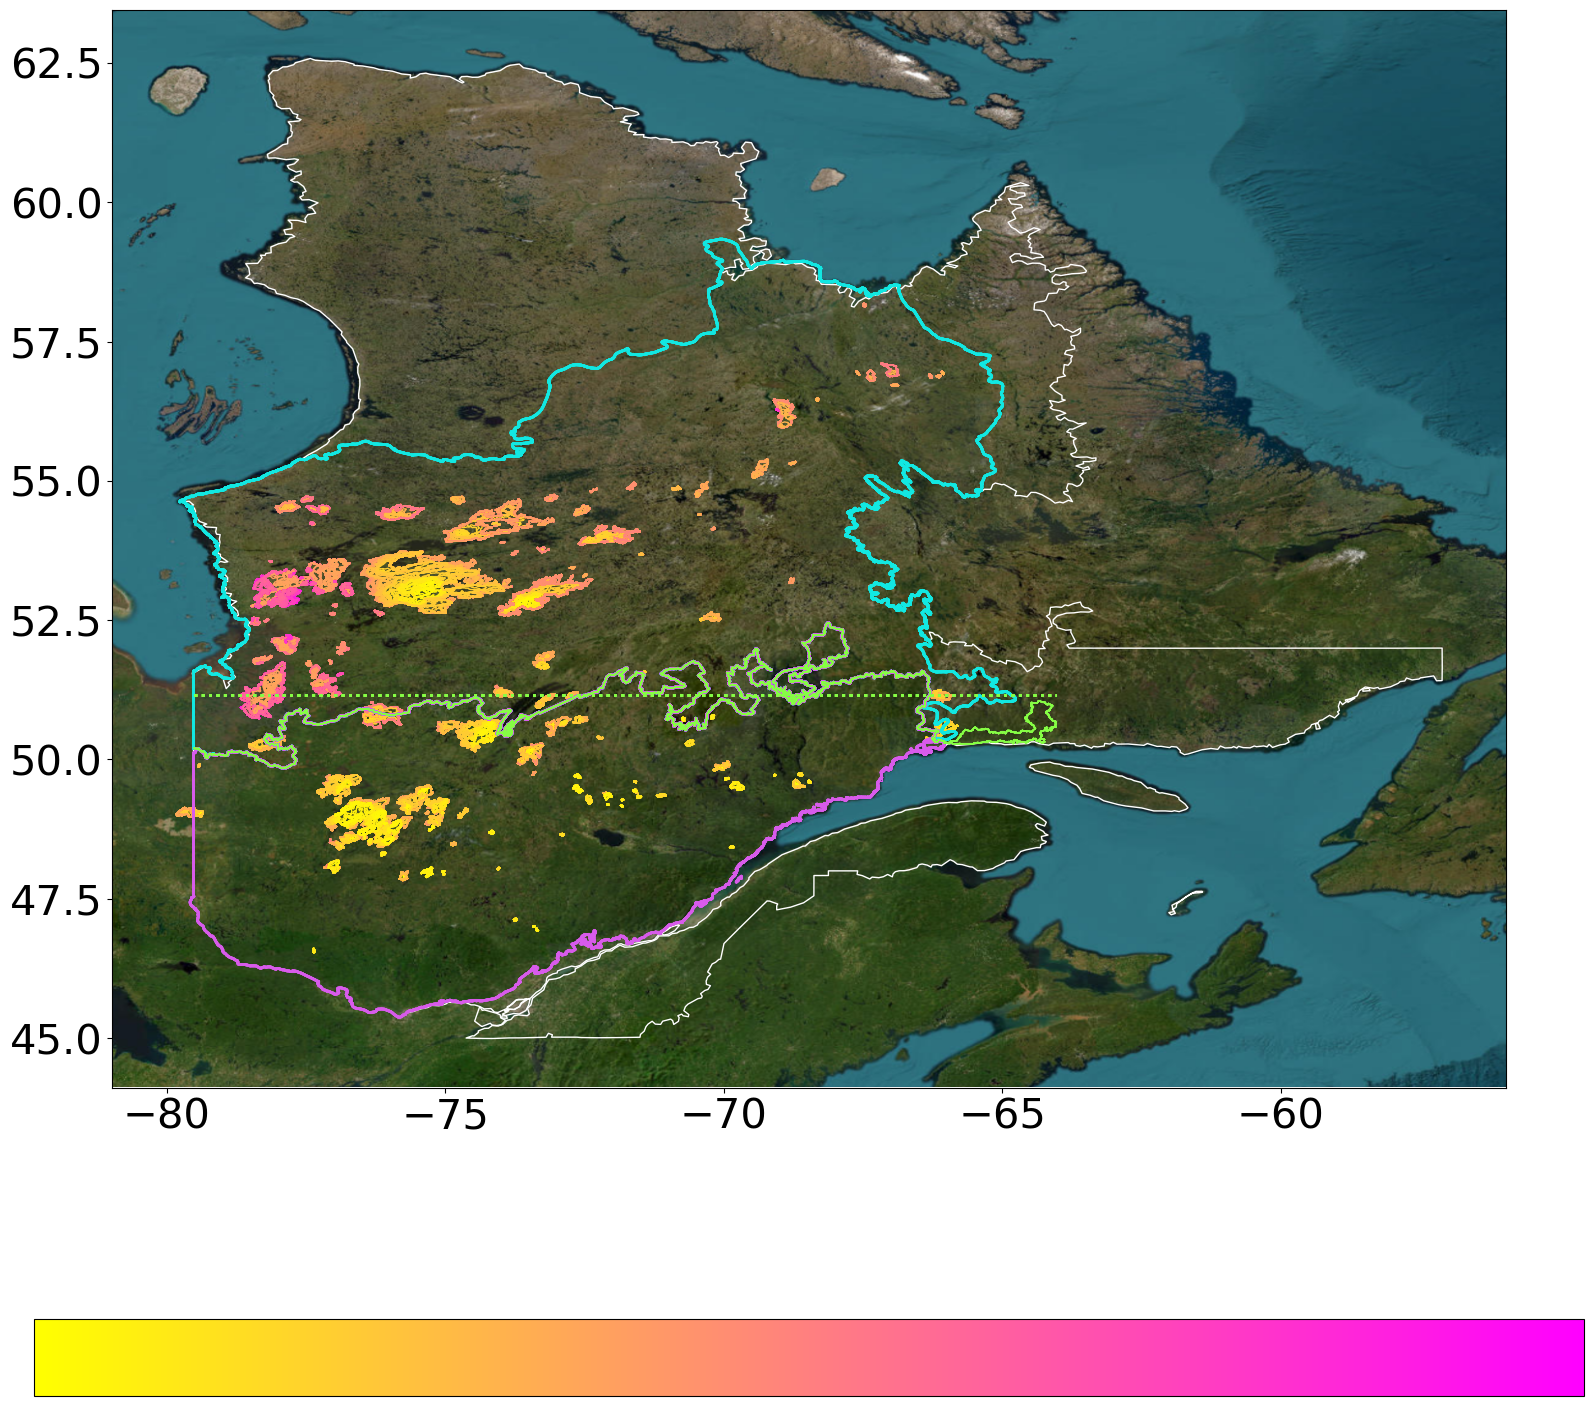

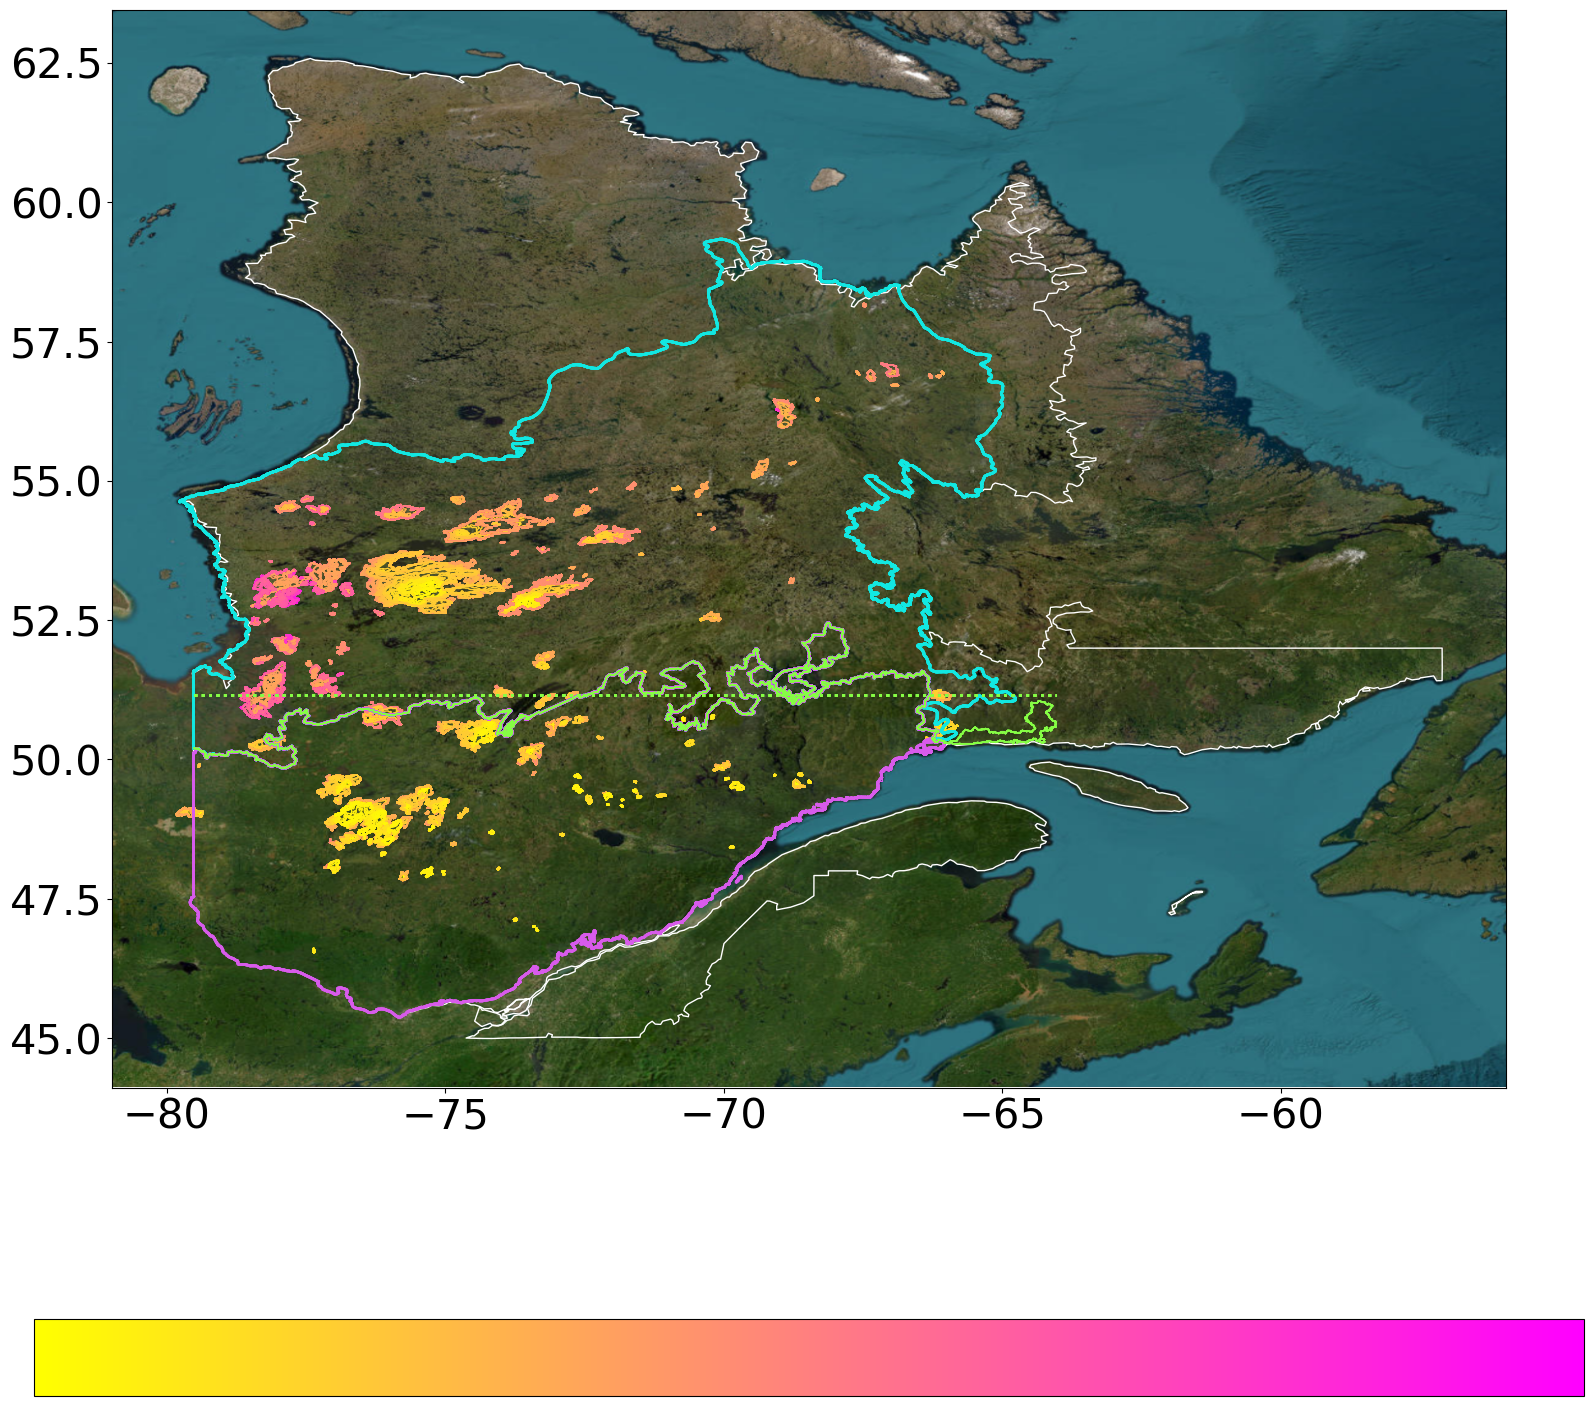

In [69]:
plt.show()

In [54]:
#proj_fires

In [109]:
# import cartopy.crs as ccrs
# import cartopy
# import matplotlib.pyplot as plt
# import matplotlib.path as mpath

# #crs = ccrs.LambertConformal()
# #crs = ccrs.PlateCarree()
# crs = ccrs.LambertConformal(central_longitude=-73.24, central_latitude=51.49)
# # This can be converted into a `proj4` string/dict compatible with GeoPandas
# crs_proj4 = crs.proj4_init



# proj_fires = proj_fires.to_crs(crs_proj4)


# # The lat-long proj
# noProj = ccrs.PlateCarree()
# # The projection of the map

# central_longitude=-73.24
# central_latitude=51.49

# dist =  2

# myProj = ccrs.LambertConformal(central_longitude=-73.24, central_latitude=51.49)
# myProj._threshold = myProj._threshold/2.  # Set for higher precision of the projection

# ax = plt.axes(projection=myProj)

# # This plots parallel and meridian arcs around a target area that will be used ...
# #  as the map boundary

# minx = proj_fires.bounds.minx.min() - dist
# maxx = proj_fires.bounds.maxx.max() + dist
# miny = proj_fires.bounds.miny.min() - dist
# maxy = proj_fires.bounds.maxy.max() + dist

# [ax_hdl] = ax.plot([minx , maxx, maxx, minx , minx ], [miny, miny, maxy, maxy, miny],
#          color='black', linewidth=0.5, marker='none',
#          transform=noProj)
# # Get the `Path` of the plot
# tx_path = ax_hdl._get_transformed_path()
# path_in_data_coords, _ = tx_path.get_transformed_path_and_affine()

# # Use the path's vertices to create a polygon
# polygon = mpath.Path( path_in_data_coords.vertices )
# ax.set_boundary(polygon) #This masks-out unwanted part of the plot
# proj_fires.plot(ax = ax, facecolor="none", column = "days_since",
#                            cmap = 'autumn_r', 
#                            legend=True, 
#                            legend_kwds={'ticks': [], "orientation":"horizontal"},)

# ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
# #ax.add_feature(cartopy.feature.OCEAN, linewidth=.3, color='lightblue')
# #ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

# ax.title.set_text("Meridians and Parallels as Boundary")
# plt.show()

In [88]:
proj_fires.bounds

minx       miny       maxx       maxy
0     -70.418504  52.499671 -70.384016  52.524917
1     -70.422866  52.496132 -70.368555  52.533138
2     -70.422866  52.494301 -70.351465  52.536009
3     -70.422866  52.494301 -70.351465  52.536009
4     -70.422866  52.494301 -70.351465  52.536009
...          ...        ...        ...        ...
10194 -72.210289  53.987599 -72.101950  54.017959
10195 -72.196258  53.987599 -72.120810  54.014931
10196 -72.187400  53.994249 -72.154222  54.013050
10197 -72.256279  53.987599 -72.083934  54.039241
10198 -72.278970  53.987599 -72.083934  54.058610

[10199 rows x 4 columns]

In [87]:
proj_fires.bounds.minx

0       -70.418504
1       -70.422866
2       -70.422866
3       -70.422866
4       -70.422866
           ...    
10194   -72.210289
10195   -72.196258
10196   -72.187400
10197   -72.256279
10198   -72.278970
Name: minx, Length: 10199, dtype: float64